In [1]:
import math
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import datasets, linear_model
import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('data/warfarin.csv')
data = data[data['Therapeutic Dose of Warfarin'].notnull()]

In [3]:
data = data.reset_index(drop=True) # fix weird row indexing 

In [4]:
def assign_bucket(n):
    if n < 21:
        return 0
    elif n > 49:
        return 2
    else:
        return 1


In [5]:
# Create a feauture vector using the features described in S1e of appx.pdf (features used in Baseline 2)
def create_feature_vec_S1e(row):
    x = np.zeros([8,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[3] = 1
    if race == 'Black or African American':
        x[4] = 1
    if race == 'Unknown':
        x[5] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[6] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[7] = 1
    
    return x



In [6]:
# Create a feature vector using the features described in S1f of appx.pdf (features used in Baseline 3)
def create_feature_vec_S1f(row):
    x = np.zeros([17,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 

    # VKORC1 
    vkorc1_ag = row.loc[index, 'VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T']
    if type(vkorc1_ag) != float:
        if vkorc1_ag == 'A/G':
            x[3] = 1
        if vkorc1_ag == 'A/A':
            x[4] = 1
        if vkorc1_ag == 'NA':
            x[5] = 1
    
    # CYP2C9 
    cyp2c9 = row.loc[index, 'Cyp2C9 genotypes']
    if type(cyp2c9) != float:
        if cyp2c9 == '*1/*2':
            x[6] = 1
        if cyp2c9 == '*1/*3':
            x[7] = 1
        if cyp2c9 == '*2/*2':
            x[8] = 1
        if cyp2c9 == '*2/*3':
            x[9] = 1
        if cyp2c9 == '*3/*3':
            x[10] = 1
        if cyp2c9 == 'NA':
            x[11] = 1
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[12] = 1
    if race == 'Black or African American':
        x[13] = 1
    if race == 'Unknown':
        x[14] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[15] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[16] = 1
    
    return x



In [7]:
def compute_dose_baseline2(row):
    index = row.index[0]
    def get_age_bucket(row):
        age =  row.loc[index, 'Age']
        if type(age) != float:
            return int(age[0])
        else: return 0


    def race_weight(row):
        race = row.loc[index,'Race']
        if race == 'Asian':
            return -.6752
        elif race == 'Black or African American':
            return .4060
        elif race == 'Unknown':
            return .0443
        else:
            return 0
    
    def enzyme_inducer(row):
        carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
        phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
        rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0
        if carbamazepine or phenytoin or rifampin:
            return 1
        else:
            return 0
    
    def amidarone(row):
        amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
        if amidarone: 
            return 1
        else: 
            return 0
        

    total = 4.0376
    total -= 0.2546 * get_age_bucket(row) 
    total += 0.0118 * row.loc[index,'Height (cm)']
    total += 0.0134 * row.loc[index,'Weight (kg)']
    total += race_weight(row) 
    total += 1.2799 * enzyme_inducer(row)
    total -= 0.5695 * amidarone(row)
    
    return total * total


In [8]:
def compute_dose_baseline3(row):
    total = 5.6044
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        total -= 0.2614 * int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        total += 0.0087 * height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        total += 0.0128 * weight 

    # VKORC1 
    vkorc1_ag = row.loc[index, 'VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T']
    if type(vkorc1_ag) != float:
        if vkorc1_ag == 'A/G':
            total -= 0.8677 * 1
        if vkorc1_ag == 'A/A':
            total -= 1.6974 * 1
        if vkorc1_ag == 'NA':
            total -= 0.4854 *1
    
    # CYP2C9 
    cyp2c9 = row.loc[index, 'Cyp2C9 genotypes']
    if type(cyp2c9) != float:
        if cyp2c9 == '*1/*2':
            total -= 0.5211 * 1
        if cyp2c9 == '*1/*3':
            total -= 0.9357 * 1
        if cyp2c9 == '*2/*2':
            total -= 1.0616 * 1
        if cyp2c9 == '*2/*3':
            total -= 1.9206 * 1
        if cyp2c9 == '*3/*3':
            total -= 2.3312 * 1
        if cyp2c9 == 'NA':
            total -= 0.2188 * 1
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        total -= 0.1092 * 1
    if race == 'Black or African American':
        total -= 0.2760 * 1
    if race == 'Unknown':
        total -= 0.1032 * 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        total += 1.1816 * 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        total -= 0.5503 * 1
    
    return total * total



In [9]:
# Generate pd Series of correct doses ([0,2])
doses = data['Therapeutic Dose of Warfarin']
doses = doses.apply(lambda dose : assign_bucket(dose)).to_numpy()
print(len(doses))
print(len(data))

5528
5528


In [11]:
class Baseline1:
    def __init__(self, T, num_a):
        self.num_a = num_a
        self.T = T
        self.rs = np.zeros((20,self.T))
        self.actions = np.zeros((20,self.T))
    def update(self, row, correct_dose, i, t):
        b1_a = 1
        self.actions[i,t] = b1_a
        b1_r = 0 if correct_dose == b1_a else -1
        self.rs[i,t] = b1_r

class Baseline2:
    def __init__(self, T, num_a):
        self.num_a = num_a
        self.T = T
        self.rs = np.zeros((20,self.T)) 
        self.actions = np.zeros((20,self.T))
    def update(self, row, correct_dose, i, t):
        a = assign_bucket(compute_dose_baseline2(row))
        self.actions[i, t] = assign_bucket(a) 
        r = 0 if correct_dose == a else -1
        self.rs[i, t] =r

class Baseline3: 
    def __init__(self, T, num_a):
        self.num_a = num_a
        self.T = T
        self.rs = np.zeros((20,self.T)) 
        self.actions = np.zeros((20,self.T))
    def update(self, row, correct_dose, i, t):
        a = assign_bucket(compute_dose_baseline3(row))
        self.actions[i, t] = assign_bucket(a) 
        r = 0 if correct_dose == a else -1
        self.rs[i, t] = r
        
class LinUCB:
    def __init__(self, T, num_a, feat_opt):
        self.T = T
        self.num_a = num_a
        self.feat_opt = feat_opt
        self.rs = np.zeros((20,T))
        self.actions = np.zeros((20,T))
        self.d = 8 if self.feat_opt == 1 else 17
        self.alpha = 1 
        self.A_list = [np.identity(self.d), np.identity(self.d), np.identity(self.d)]
        self.b_list = [np.zeros([self.d,1]), np.zeros([self.d,1]), np.zeros([self.d,1])]
    def update(self, row, correct_dose, i, t):
        x = create_feature_vec_S1e(row) if self.feat_opt == 1 else create_feature_vec_S1f(row)

        p = np.zeros(self.num_a)
        for a in range(self.num_a):
            A = self.A_list[a]
            b = self.b_list[a]
            A_inv = np.linalg.inv(A)
            theta = A_inv @ b
            p[a] = theta.T @ x + self.alpha * np.sqrt(x.T @ A_inv @ x)
        
        a = np.argmax(p)
        self.actions[i,t] = a
        r = 0 if correct_dose == a else -1
        self.rs[i, t] = r

        self.A_list[a] = self.A_list[a] + x @ x.T
        self.b_list[a] = self.b_list[a] + r * x

class ThompsonSampling:
    def __init__(self, T, num_a, feat_opt):
        self.T = T
        self.num_a = num_a
        self.feat_opt = feat_opt
        self.rs = np.zeros((20,self.T))
        self.actions = np.zeros((20,self.T))
        self.d = 8 if self.feat_opt == 1 else 17
        self.R = 1
        self.eps = 1 / np.log(self.T)
        self.delta = .1
        self.v = 0.2 #tsamp1_R * np.sqrt(24 / tsamp1_eps * tsamp1_d * np.log(1 / tsamp1_delta))

        self.B_list = [np.identity(self.d), np.identity(self.d), np.identity(self.d)]
        self.mu_hat_list = [np.zeros(self.d), np.zeros(self.d), np.zeros(self.d)]
        self.f_list = [np.zeros(self.d), np.zeros(self.d), np.zeros(self.d)]
    def update(self, row, correct_dose, i, t):
        x = create_feature_vec_S1e(row) if self.feat_opt == 1 else create_feature_vec_S1f(row)
        mu_tildes = [np.random.multivariate_normal(mu_hat, self.v * self.v * np.linalg.inv(B)) for mu_hat, B in zip(self.mu_hat_list, self.B_list)]
        arm_scores = [x.T @ mu_tilde for mu_tilde in mu_tildes]

        a = np.argmax(arm_scores)
        self.actions[i,t] = a
        r = 0 if correct_dose == a else -1
        self.rs[i, t] = r    

        self.B_list[a] += x @ x.T
        self.f_list[a] += x.squeeze() * r
        self.mu_hat_list[a] = np.linalg.inv(self.B_list[a]) @ self.f_list[a]
    
class LinearRegression: 
    def __init__(self, T, num_a, feat_opt):
        self.T = T
        self.num_a = num_a
        self.feat_opt = feat_opt
        self.d = 8 if self.feat_opt == 1 else 17
        self.model = linear_model.LinearRegression()
        self.model.fit(np.random.rand(1,self.d), np.asarray([1]))
        self.Xtrain = np.array([])
        self.ytrain = np.array([])
        self.rs = np.zeros((20,self.T))
        self.actions = np.zeros((20,self.T))
    def update(self, row, correct_dose, i, t):
        feats = create_feature_vec_S1e(row) if self.feat_opt == 1 else create_feature_vec_S1f(row)
        x = np.reshape(feats, (1, self.d))
        a = assign_bucket(self.model.predict(x))
        y = np.asarray([correct_dose])
        r = 0 if correct_dose == a else -1 
        self.Xtrain = np.vstack([self.Xtrain,x]) if self.Xtrain.size else x
        self.ytrain = np.vstack([self.ytrain, y]) if self.ytrain.size else y
        self.model.fit(self.Xtrain, self.ytrain)
        self.actions[i,t] = a
        self.rs[i, t] = r

class LASSO: 
    def __init__(self, T, num_a, feat_opt):
        self.T = T
        self.num_a = num_a
        self.feat_opt = feat_opt
        self.Sr=np.empty((self.num_a, 0)).tolist()
        self.Sx=np.empty((self.num_a, 0)).tolist()
        self.d = 8 if feat_opt == 1 else 17
        self.q = 1
        self.h = 5
        self.lam1 = 0.05
        self.lam2 = 0.05
        self.beta_t=np.zeros((self.num_a, self.num_a * self.d))
        self.beta_a=np.zeros((self.num_a, self.num_a * self.d))
        self.n=0
        self.lasso_t=linear_model.Lasso(alpha=self.lam1) 
        self.rs = np.zeros((20,self.T))
        self.actions = np.zeros((20,self.T))
    def update(self, row, correct_dose, i, t):
        if t == ((2 ** self.n - 1) * self.num_a * self.q + 1):
            self.set = np.arange(t, t + self.q * self.num_a)
            self.n += 1

        feats = create_feature_vec_S1e(row) if self.feat_opt == 1 else create_feature_vec_S1f(row)
        x = np.vstack([feats, feats, feats]).squeeze(1)
        est = np.dot(self.beta_t, x)
        max_est = np.amax(est)
        self.K = np.argwhere(est > max_est - self.h / 2.0)
        est2 = [np.dot(x, self.beta_a[k[0]]) for k in self.K]
        a = self.K[np.argmax(est2)][0]

        self.actions[i,t] = a
        r = 0 if correct_dose == a else -1
        self.rs[i, t] = r
        self.Sx[a].append(x)

        self.Sr[a].append(r)
        lam2_t = self.lam2 * np.sqrt((np.log(t) + np.log(self.num_a * self.d)) / t)
        lasso_a = linear_model.Lasso(alpha = lam2_t)
        if t > 5:
            lasso_a.fit(self.Sx[a],self.Sr[a])
            self.beta_a[a] = lasso_a.coef_


        

In [14]:
T = len(data)
num_a = 3
correct_doses = np.zeros((20, T))

# Baseline 1
baseline1 = Baseline1(T, num_a)

# Baseline 2 
baseline2 = Baseline2(T, num_a)

# Baseline 3 
baseline3 = Baseline3(T, num_a)

# LinUCB S1e features 
linucb1 = LinUCB(T, num_a, 1)

# LinUCB S1f features 
linucb2 = LinUCB(T, num_a, 2)

# Thompson Sampling 1
tsamp1 = ThompsonSampling(T, num_a, 1)

# Thompson Sampling 2
tsamp2 = ThompsonSampling(T, num_a, 2)

# Linear Regression 1
linreg1 = LinearRegression(T, num_a, 1)

# Linear Regression 2 
linreg2 = LinearRegression(T, num_a, 2)

# LASSO 
# lasso = LASSO(T, num_a, 1)



# Do 20 runs 
for i in tqdm(range(20)):
    # LinUCB - reset A and b lists
    linucb1.A_list = [np.identity(linucb1.d), np.identity(linucb1.d), np.identity(linucb1.d)]
    linucb1.b_list = [np.zeros([linucb1.d,1]), np.zeros([linucb1.d,1]), np.zeros([linucb1.d,1])]

    linucb2.A_list = [np.identity(linucb2.d), np.identity(linucb2.d), np.identity(linucb2.d)]
    linucb2.b_list = [np.zeros([linucb2.d,1]), np.zeros([linucb2.d,1]), np.zeros([linucb2.d,1])]
    # Loop over all timesteps T in dataset 
    for t in range(T):
        # Sample random row 
        row = data.sample(replace=False)
        # row = data.loc[[t]]
        
        # Get correct action
        correct_dose = doses[row.index[0]]
        correct_doses[i,t] = correct_dose

        # Baseline 1 
        baseline1.update(row, correct_dose, i, t)

        # Baseline 2
        baseline2.update(row, correct_dose, i, t)

        # Baseline 3 
        baseline3.update(row, correct_dose, i, t)

        # LinUCB 1
        linucb1.update(row, correct_dose, i , t)
        
        # LinUCB 2
        linucb2.update(row, correct_dose, i, t)
        
        # Thompson Sampling 1
        tsamp1.update(row, correct_dose, i, t)
        
        # Thompson Sampling 2 
        tsamp2.update(row, correct_dose, i, t)

        # Linear Regression 1 
        linreg1.update(row, correct_dose, i, t)

        # Linear Regression 2 
        linreg2.update(row, correct_dose, i, t)

        # LASSO 
        # lasso.update(row, correct_dose, i, t)
        


 25%|██▌       | 5/20 [09:41<33:05, 132.36s/it]

In [ ]:
linreg1_Xtrain = np.array([])
linreg1_ytrain = np.array([])

for i in range(T):
    row = row = data.loc[[t]]
    correct_dose = doses[t]
    x = np.reshape(create_feature_vec_S1e(row), (1, linreg1_d))
    y = np.asarray([correct_dose])
    linreg1_Xtrain = np.vstack([linreg1_Xtrain,x]) if linreg1_Xtrain.size else x
    linreg1_ytrain = np.vstack([linreg1_ytrain, y]) if linreg1_ytrain.size else y

linreg1_model = linear_model.LinearRegression()
linreg1_model.fit(linreg1_Xtrain, linreg1_ytrain)
pred_doses = linreg1_model.predict(linreg1_Xtrain)
num_wrong = np.count_nonzero(pred_doses.squeeze(1) - doses)
print(num_wrong/T)

0.388205499276411


In [ ]:
np.savetxt('baseline1_rs.txt', baseline1.rs)
np.savetxt('baseline2_rs.txt', baseline2.rs)
np.savetxt('baseline3_rs.txt', baseline3.rs)
np.savetxt('linucb1_rs.txt', linucb1.rs)
np.savetxt('linucb2_rs.txt', linucb2.rs)
np.savetxt('tsamp1_rs.txt', tsamp1.rs)
np.savetxt('tsamp2_rs.txt', tsamp2.rs)
np.savetxt('linreg1_rs.txt', linreg1.rs)
np.savetxt('linreg2_rs.txt', linreg2.rs)
# np.savetxt('lasso_rs.txt', lasso.rs)

In [ ]:
def plot_regret_wrong_mse(rewards, correct_doses, actions, ax_regret, ax_incorrect, ax_mse, label, color):
    """ Compute the cumulative regret over time and the percent of wrong actions over time and plot
        with 95% confidence intervals using t distribution. 

        rewards: np array of size (20,T) """
    regret = np.cumsum(rewards, axis=1)
    mean_regret = np.abs(np.mean(regret, axis=0))
    frac_incorrect = np.abs(regret) / np.linspace(1,np.size(rewards,1), num = np.size(rewards,1))
    mean_frac_incorrect = np.mean(frac_incorrect, axis=0)
    squared_error = np.square(actions - correct_doses)
    mse = np.cumsum(squared_error, axis=1) / np.linspace(1,np.size(rewards,1), num = np.size(rewards,1))
    mean_mse = np.mean(mse, axis=0)
    

    regret_int_upper = []
    regret_int_lower = []
    incorrect_int_upper = []
    incorrect_int_lower = []
    mse_int_upper = []
    mse_int_lower = []

    for t in range(np.size(rewards,1)):
        regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[t], scale= st.sem(regret[:,t]))
        regret_int_upper.append(regret_bounds[1])
        regret_int_lower.append(regret_bounds[0])

        incorrect_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_frac_incorrect[t], scale= st.sem(frac_incorrect[:,t]))
        incorrect_int_upper.append(incorrect_bounds[1])
        incorrect_int_lower.append(incorrect_bounds[0])

        mse_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_mse[t], scale= st.sem(mse[:,t]))
        mse_int_upper.append(mse_bounds[1])
        mse_int_lower.append(mse_bounds[0])

    
    ts = np.linspace(0,np.size(rewards,1), num = np.size(rewards,1))
    ax_regret.plot(ts, mean_regret, label=label, color=color)
    ax_regret.fill_between(ts,regret_int_lower, regret_int_upper, color=color, alpha = 0.3)
    ax_incorrect.plot(ts, mean_frac_incorrect, label=label, color=color)
    ax_incorrect.fill_between(ts, incorrect_int_lower, incorrect_int_upper, color=color, alpha = 0.3)
    ax_mse.plot(ts, mean_mse, label=label, color=color)
    ax_mse.fill_between(ts, mse_int_lower, mse_int_upper, color=color, alpha = 0.3)
    



/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/903614356.py:17: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[t], scale= st.sem(regret[:,t]))
/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/903614356.py:21: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  incorrect_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_frac_incorrect[t], scale= st.sem(frac_incorrect[:,t]))


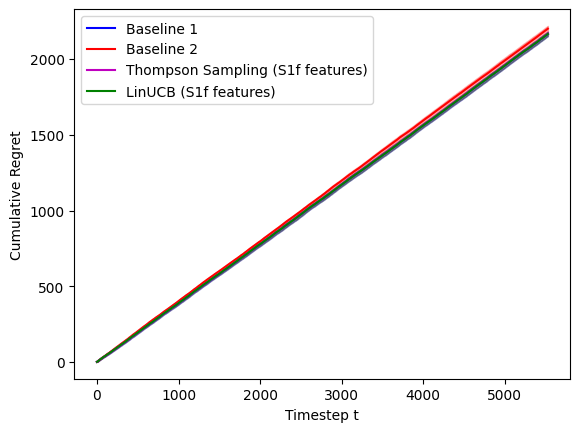

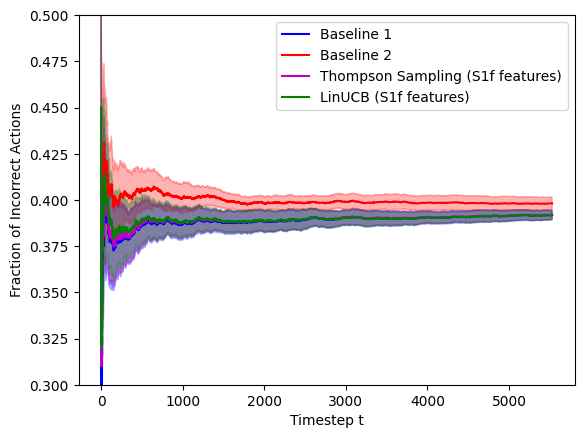

In [ ]:
# plotting 
fig1, ax1 = plt.subplots()
fig2, ax2  = plt.subplots()
fig3, ax3 = plt.subplots()
ax1.set_xlabel('Timestep t')
ax2.set_xlabel('Timestep t')
ax3.set_xlabel('Timestep t')
ax1.set_ylabel('Cumulative Regret')
ax2.set_ylabel('Fraction of Incorrect Actions')
ax3.set_ylabel('MSE')

plot_regret_wrong_mse(baseline1.rs, correct_doses, baseline1.actions, ax1, ax2, ax3, 'Baseline 1', 'b')
plot_regret_wrong_mse(baseline2.rs, correct_doses, baseline2.actions, ax1, ax2, ax3, 'Baseline 2', 'r')
plot_regret_wrong_mse(tsamp1.rs, correct_doses, tsamp1.actions, ax1, ax2, ax3, 'Thompson Sampling (S1f features)', 'm')
plot_regret_wrong_mse(linucb1.rs, correct_doses, linucb1.actions, ax1, ax2, ax3, 'LinUCB (S1f features)', 'g')
# plot_regret_wrong(linreg1.rs, ax1, ax2, 'Linear Regression (S1f features)', 'darkorange')
# plot_regret_wrong(lasso.rs, ax1, ax2, 'LASSO(S1f features)', 'c')

ax1.legend()
ax2.legend()
ax2.set_ylim([0.3, 0.5])
plt.show()

/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/903614356.py:17: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[t], scale= st.sem(regret[:,t]))
/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/903614356.py:21: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  incorrect_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_frac_incorrect[t], scale= st.sem(frac_incorrect[:,t]))


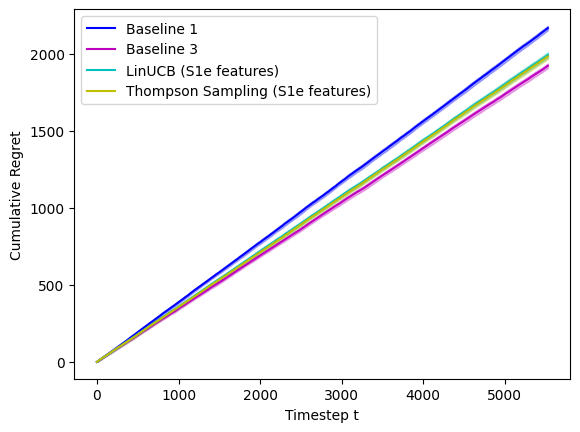

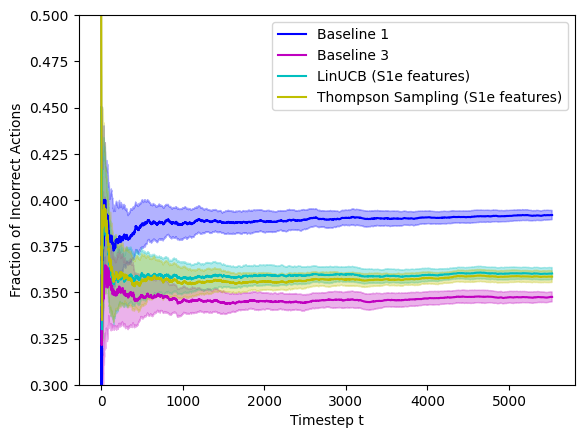

In [ ]:
# plotting 
fig1, ax1 = plt.subplots()
fig2, ax2  = plt.subplots()
fig3, ax3 = plt.subplots()
ax1.set_xlabel('Timestep t')
ax2.set_xlabel('Timestep t')
ax3.set_xlabel('Timestep t')
ax1.set_ylabel('Cumulative Regret')
ax2.set_ylabel('Fraction of Incorrect Actions')
ax3.set_ylabel('MSE')

plot_regret_wrong_mse(baseline1.rs, correct_doses, baseline1.actions, ax1, ax2, ax3, 'Baseline 1', 'b')
plot_regret_wrong_mse(baseline3.rs, correct_doses, baseline3.actions, ax1, ax2, ax3, 'Baseline 3', 'm')
plot_regret_wrong_mse(linucb2.rs, correct_doses, linucb2.actions, ax1, ax2, ax3, 'LinUCB (S1e features)', 'c')
plot_regret_wrong_mse(tsamp2.rs, correct_doses, tsamp2.actions, ax1, ax2, ax3, 'Thompson Sampling (S1e features)', 'y')
# plot_regret_wrong(linreg2.rs, ax1, ax2, 'Linear Regression (S1e features)', 'darkorange')

ax1.legend()
ax2.legend()
ax2.set_ylim([0.3, 0.5])
plt.show()